# JAX Binary Neural Network
In this notebook, we implement a binary neural network using the JAX framework. Neural networks have proven to be powerful models for solving a wide range of real-world tasks. However, as models grow in complexity, their increasing number of parameters makes them significantly more expensive to store and run, especially on memory-constrained hardware like RAM or GPUs.

A popular approach to reduce model size is quantization, which aims to decrease the bit-width of each parameter. Standard methods often quantize only the model's weights (e.g., to 8-bit integers) while leaving activations in floating-point, which still leaves room for further optimization. This raises an interesting question: what if we take this to the extreme? Is it possible to train a functional neural network where both the weights and the activations are binary (i.e., having a value of either -1 or 1)?

This notebook explores this question by building a simple MLP architecture for the MNIST dataset. Simply converting a pre-trained, full-precision MLP to a binary one is guaranteed to fail due to the massive loss of information. Instead, we train the network in its binary form directly. To make this possible, we introduce two key modifications to the standard training process:
1. **Binarization**: We constrain all inputs, weights, and activations to values of either -1 or 1.
2. **Gradient Approximation**: Since the binarization function is non-differentiable, we leverage the Straight-Through Estimator (STE) to approximate gradients, enabling the use of standard backpropagation.

Beyond academic curiosity, binary neural networks have significant practical applications. For instance, they are ideal for deployment on resource-constrained IoT devices. By running a model directly on a device, we can enable on-device processing, eliminating the latency and cost of API calls to a remote server. This creates opportunities for many new intelligent, edge-computing applications.

Furthermore, binary networks are exceptionally efficient. The multiplication of two values from the set {-1, 1} is equivalent to a logical XNOR operation. This allows the expensive floating-point multiplications found in standard networks to be replaced with highly efficient bitwise operations, dramatically accelerating inference speed.


## Library

We use a few key libraries to build and train our network:
*   **JAX** and **NumPy**: For high-performance numerical computation and array manipulation.
*   **Optax**: A flexible optimization library built for JAX, which we use to implement our Adam optimizer.
*   **Keras**: We use `keras.datasets` for a convenient way to download and load the MNIST dataset.
*   **`jax.lax.stop_gradient`**: This function is the cornerstone of our implementation. It allows us to implement the Straight-Through Estimator by selectively blocking gradients during the backward pass, which is essential for training our non-differentiable binary network.

In [15]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad
from jax.lax import stop_gradient
import optax

import matplotlib.pyplot as plt

from keras.datasets import mnist

## Preprocessing

We preprocess the input data to align with the binary nature of our network. The goal is to convert each input image into a vector of -1s and 1s.

This is done in three steps:
1.  **Normalization**: We first scale the raw pixel values from their original `[0, 255]` range to a new range of `[-1, 1]`.
2.  **Binarization**: We then discretize these normalized values. Any pixel value less than 0 is set to -1, and any value greater than or equal to 0 is set to 1. This effectively converts the grayscale images into stark black-and-white versions.
3.  **Reshaping**: Finally, we flatten each 28x28 image into a single 784-element vector, preparing the data to be fed into the input layer of our MLP.

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(len(x_train), -1)/255*2-1
x_test = x_test.reshape(len(x_test), -1)/255*2-1

x_train = (x_train > 0)*2-1
x_test = (x_test > 0)*2-1

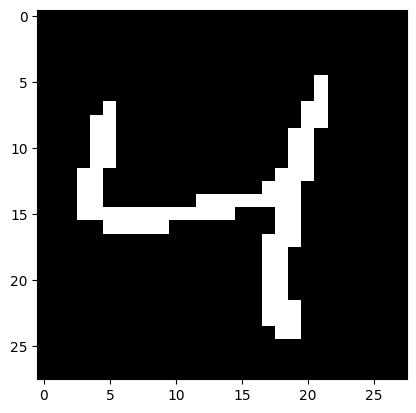

In [21]:
plt.imshow(x_train[2].reshape(28,28), cmap = 'gray')

## Define the Binary Layer

Our objective is to create a binary equivalent of a standard linear layer. This layer will operate exclusively with binary weights and produce binary outputs (vectors of -1s and 1s).

The primary challenge is that the binarization process (a step function) is non-differentiable, which prevents standard backpropagation. To overcome this, we employ the **Straight-Through Estimator (STE)**. Our implementation of STE relies on a dual-path forward pass:

1.  **The Binary Forward Pass (For Inference):** This is the "true" computation. It takes the underlying full-precision weights, binarizes them to strict `{-1, 1}` values, and performs the matrix multiplication. The resulting activations are also binarized. This path is used to get the model's actual output.

2.  **The Continuous Forward Pass (For Gradients):** This is a "proxy" path used only for calculating gradients. Instead of a hard binarization, we use the `tanh()` function as a smooth, differentiable approximation. We apply `tanh()` to both the latent weights and the pre-activations. The gradients from this continuous path will serve as an estimate for the non-differentiable binary path.

The `stop_gradient` function is the key that allows us to combine these two paths. In essence, during the forward pass, we compute the true binary output. During the backward pass, JAX computes gradients as if the forward pass had been the continuous `tanh`-based version.

To ensure stable training from the start, we initialize the latent, full-precision weights using **He initialization**, a standard practice for deep networks.

In [22]:
class BinaryLinear() :
  def __init__(self, in_dim, out_dim) :
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.init_std = (2/self.in_dim)**(1/2)

  def get_parameters(self) :
    temp_params = np.random.randn(self.in_dim, self.out_dim)*self.init_std
    temp_params = jnp.array(temp_params)

    return temp_params

  @staticmethod
  def binarize_params(parameters) :
    binary_params = jnp.tanh(parameters)
    binary_params = binary_params > 0
    binary_params = (binary_params*2) - 1

    return binary_params

  @staticmethod
  def full_cont_forward(parameters, x) :
    binary_params_cont = jnp.tanh(parameters)
    act_now = jnp.tanh(x @ binary_params_cont)

    return act_now

  @staticmethod
  def binary_forward(binary_parameters, x) :
    out_now = jnp.tanh(x @ binary_parameters)
    return (out_now > 0)*2-1

  @staticmethod
  def forward(parameters,  x) :
    binary_params = BinaryLinear.binarize_params(parameters)
    out_now = BinaryLinear.binary_forward(binary_params, x)

    act_now = BinaryLinear.full_cont_forward(parameters, x)
    # straight through estimator
    out_now = out_now + act_now - stop_gradient(act_now)

    return out_now

## Assembling the Full Binary MLP

With our `BinaryLinear` layer defined, we have the fundamental building block of our network. We can now construct a complete multi-layer perceptron (MLP) simply by stacking these layers. The output of each binary layer serves as the input to the next, allowing us to seamlessly extend the architecture to the desired depth.

In [23]:
class BinaryModel() :
  def __init__(self, in_dim, hidden_dim, out_dim, num_hidden_layers = 1) :
    self.in_dim = in_dim
    self.hidden_dim = hidden_dim
    self.out_dim = out_dim
    self.num_hidden_layers = num_hidden_layers


  def get_parameters(self) :
    params = [BinaryLinear(self.in_dim, self.hidden_dim).get_parameters()]
    for i in range(self.num_hidden_layers) :
      params.append(BinaryLinear(self.hidden_dim, self.hidden_dim).get_parameters())
    params.append(BinaryLinear(self.hidden_dim, self.out_dim).get_parameters())

    return params

  @staticmethod
  def binarize_params(parameters) :
    binary_params = [BinaryLinear.binarize_params(param) for param in parameters]
    return binary_params

  @staticmethod
  def binary_forward(binary_parameters, x) :
    out_now = x
    for param_now in binary_parameters :
      out_now = BinaryLinear.binary_forward(param_now, out_now)

    return out_now

  @staticmethod
  def forward(parameters,  x) :
    out_now = x
    for param_now in parameters :
      out_now = BinaryLinear.forward(param_now, out_now)

    return out_now

## Loss Function

To train the network, we need a way to measure the difference between the model's predictions and the actual labels. For this multi-class classification task, we use the standard **cross-entropy loss**.

Since the final layer of our network outputs raw scores (logits), we first apply a **softmax function** to convert these scores into a valid probability distribution across the 10 classes. The cross-entropy loss then quantifies how well this predicted probability distribution matches the true label.

In [5]:
def jnp_softmax(x, dim = -1) :
  exp_x = jnp.exp(x)
  exp_x = exp_x/jnp.sum(exp_x, dim, keepdims=True)
  return exp_x

In [6]:
def compute_loss(parameters, data_x, data_y) :
  yhat = BinaryModel.forward(parameters, data_x)
  prediction = jnp_softmax(yhat)

  loss = -jnp.log(prediction[np.arange(len(data_x)), data_y])
  loss = jnp.mean(loss)

  return loss

compute_grad_loss = jax.value_and_grad(compute_loss)
compute_grad_loss = jax.jit(compute_grad_loss)

## Training the Network

We are now ready to train the model. Our architecture is a **Binary MLP** with two hidden layers, each containing 512 neurons. This network is designed to take a flattened, binarized MNIST image as input and produce a 10-dimensional output vector representing the scores for each digit (0-9).

To optimize the network's latent (full-precision) parameters, we will use the **Adam optimizer**, a robust adaptive learning rate algorithm, implemented using the **Optax** library. We'll train the model on mini-batches of data for a set number of iterations, periodically evaluating its accuracy on the test set to monitor progress.

In [26]:
model = BinaryModel(28*28,512,10,2)
start_learning_rate = 3e-4
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = model.get_parameters()
opt_state = optimizer.init(params)

In [27]:
num_itr = 5000
batch_size = 512

for i in range(num_itr) :
  rand_data = np.random.randint(0, len(x_train), batch_size)
  x_now = x_train[rand_data]
  y_now = y_train[rand_data]


  value, grads = compute_grad_loss(params, x_now, y_now)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  if i % 250 == 0 :
    print(i, value, grads[0].sum(), params[0].sum())

    num_data = 10000
    yhat_test = model.binary_forward(model.binarize_params(params), x_test[0:num_data])
    acc_now = np.mean(yhat_test.argmax(-1) == y_test[0:num_data])
    print("ACCURACY:", acc_now)

yhat_test = model.binary_forward(model.binarize_params(params), x_test[0:num_data])
acc_now = np.mean(yhat_test.argmax(-1) == y_test[0:num_data])
print("ACCURACY:", acc_now)


0 2.7289264 -5.5207934 31.925497
ACCURACY: 0.1267
250 1.0726473 -0.8413658 3.5015996
ACCURACY: 0.8134
500 0.98680985 11.956423 12.326802
ACCURACY: 0.88009995
750 0.92737806 -4.7224736 2.4974375
ACCURACY: 0.8943
1000 0.9149725 5.777484 15.63731
ACCURACY: 0.9083
1250 0.8944127 4.981589 12.1899805
ACCURACY: 0.9184
1500 0.91286755 1.9172374 13.0103445
ACCURACY: 0.9187
1750 0.8621817 -1.9354597 1.457814
ACCURACY: 0.937
2000 0.870172 -0.2024888 16.750154
ACCURACY: 0.9388
2250 0.8579543 5.9929247 18.360256
ACCURACY: 0.93659997
2500 0.85207164 -3.8809388 10.52321
ACCURACY: 0.9411
2750 0.8484864 2.0417485 30.328266
ACCURACY: 0.9429
3000 0.85372627 3.1673765 25.864372
ACCURACY: 0.94939995
3250 0.8898465 -5.752628 25.04128
ACCURACY: 0.94369996
3500 0.83574003 2.9791057 10.119284
ACCURACY: 0.94879997
3750 0.8424428 -2.888378 12.361624
ACCURACY: 0.9554
4000 0.8423771 0.8031699 19.783243
ACCURACY: 0.94909996
4250 0.8234898 0.15095502 36.644356
ACCURACY: 0.9478
4500 0.84210366 -5.8466005 29.090614
AC

In [31]:
num_data = 10000
yhat = model.binary_forward(model.binarize_params(params), x_test[0:num_data])
acc_now = np.mean(yhat.argmax(-1) == y_test[0:num_data])
print("ACCURACY:", acc_now)

ACCURACY: 0.9539


## Checking The Binary Parameters

In [29]:
model.binarize_params(params)

[Array([[-1,  1, -1, ...,  1,  1, -1],
        [ 1,  1,  1, ..., -1, -1,  1],
        [-1,  1, -1, ..., -1,  1,  1],
        ...,
        [ 1,  1,  1, ...,  1,  1, -1],
        [-1, -1,  1, ..., -1,  1, -1],
        [ 1, -1,  1, ...,  1,  1, -1]], dtype=int32, weak_type=True),
 Array([[ 1, -1, -1, ...,  1, -1, -1],
        [ 1, -1,  1, ..., -1, -1,  1],
        [-1,  1, -1, ...,  1, -1,  1],
        ...,
        [ 1, -1,  1, ..., -1,  1, -1],
        [ 1,  1, -1, ...,  1, -1,  1],
        [ 1,  1, -1, ...,  1,  1, -1]], dtype=int32, weak_type=True),
 Array([[-1,  1, -1, ...,  1,  1, -1],
        [ 1, -1,  1, ...,  1, -1, -1],
        [-1,  1, -1, ...,  1,  1,  1],
        ...,
        [ 1, -1, -1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1, -1, -1],
        [ 1, -1,  1, ..., -1, -1,  1]], dtype=int32, weak_type=True),
 Array([[ 1,  1, -1, ..., -1,  1,  1],
        [ 1,  1,  1, ...,  1, -1,  1],
        [ 1,  1, -1, ...,  1, -1,  1],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1

## Conclusion

We have successfully trained a multi-layer perceptron on the MNIST dataset where both the weights and activations are fully binary. While MNIST is a relatively simple benchmark, this project serves as a clear proof-of-concept, demonstrating that it is possible to train these highly constrained networks from scratch using the Straight-Through Estimator.

Our simple binary MLP achieved an accuracy of approximately **95%**. This is a noteworthy result, validating that even with such extreme quantization, the model can learn meaningful representations. However, it's important to place this in context: a significant performance gap remains when compared to standard full-precision MLPs or more sophisticated binary network architectures, which routinely achieve accuracies exceeding 98-99% on this task.

Ultimately, this experiment highlights the immense potential of binary neural networks. Their dramatically reduced memory footprint and the ability to replace expensive floating-point multiplications with efficient bitwise operations make them a compelling solution for deploying AI on resource-constrained hardware, such as IoT devices and edge sensors. This work lays the groundwork for exploring more advanced binary architectures and tackling more complex problems in the future.

## References


*   Jax Documentation, https://docs.jax.dev/en/latest/
*   Optax Documentation, https://optax.readthedocs.io/
*   Original Binary NN, https://arxiv.org/pdf/1602.02830
*   Straight-Throught Estimator, https://arxiv.org/abs/1308.3432
*   Adam Optimizer, https://arxiv.org/abs/1412.6980

